In [1]:
import pandas as pd
import numpy as np
import torch
import glob
import os
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


# Weather

In [2]:
def load_dataset_from_dir(directory_path):
    """Loads and processes CSV files from a given directory into a single PyTorch tensor."""
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    tensors = []

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)

            # Drop datetime column if present
            if 'dt_UTC01_NoDLS' in df.columns:
                df = df.drop(columns='dt_UTC01_NoDLS')

            # Ensure all values are numeric
            df = df.apply(pd.to_numeric, errors='coerce')

            # Drop rows with NaNs
            df = df.dropna()

            # Drop rows where the sum is < 25
            df = df[df.sum(axis=1) >= 25]

            # Convert to tensor and collect
            if not df.empty:
                tensor_chunk = torch.tensor(df.values, dtype=torch.float32)
                tensors.append(tensor_chunk)
            else:
                print(f"⚠️ File {file_path} has no valid rows after filtering.")

        except Exception as e:
            print(f"⚠️ Skipping file {file_path} due to error: {e}")

    # Final concatenation
    if tensors:
        data_tensor = torch.cat(tensors, dim=0)
        print(f"✅ Loaded {len(tensors)} chunks from {directory_path}. Final shape: {data_tensor.shape}")
        return data_tensor
    else:
        print(f"⚠️ No valid data loaded from {directory_path}.")
        return None

# Process each dataset
train_tensor = load_dataset_from_dir('dat/train')
val_tensor   = load_dataset_from_dir('dat/val')
test_tensor  = load_dataset_from_dir('dat/test')


⚠️ File dat/train/tc_2020-07-25_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-05-01_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-07-12_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-07-04_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-09-03_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-11_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-22_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-02_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-30_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-06-04_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-04-16_full_day.csv has no valid rows after filtering.
⚠️ File dat/train/tc_2020-08-13_full_day

# do not run 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = train_tensor.to(device)
print(f"Tensor is on: {data_tensor.device}")

Tensor is on: cuda:0


In [4]:
print("Tensor shape:", data_tensor.shape)  # (N, 801), where N is the number of time stamps

Tensor shape: torch.Size([935847, 801])


In [5]:
# # Min-max normalization
min_vals = data_tensor.min(dim=0, keepdim=True).values
max_vals = data_tensor.max(dim=1, keepdim=True).values

# Avoid divide-by-zero by adding a small epsilon
normalized_tensor = (data_tensor) / (max_vals + 1e-8)

# normalized_tensor = data_tensor



# Wrap data into a TensorDataset and DataLoader
dataset = TensorDataset(normalized_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [6]:
max_vals.shape

torch.Size([935847, 1])

In [6]:
# Define the DAE model
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 400), nn.ReLU(),
            nn.Linear(400, 200), nn.ReLU(),
            nn.Linear(200, 100), nn.ReLU(),
            nn.Linear(100, 6)
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, 100), nn.ReLU(),
            nn.Linear(100, 200), nn.ReLU(),
            nn.Linear(200, 400), nn.ReLU(),
            nn.Linear(400, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [3]:
def evaluate_loss(model, data_tensor, batch_size=512):
    loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=False)
    total_loss = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

    return total_loss / total_samples

# DO NOT TRAIN UNLESS NECCESSARY

Using device: cuda
Epoch 01/50 - Train Loss: 0.00135 | Val Loss: 0.00069
Epoch 02/50 - Train Loss: 0.00061 | Val Loss: 0.00062
Epoch 03/50 - Train Loss: 0.00056 | Val Loss: 0.00059
Epoch 04/50 - Train Loss: 0.00054 | Val Loss: 0.00060
Epoch 05/50 - Train Loss: 0.00053 | Val Loss: 0.00059
Epoch 06/50 - Train Loss: 0.00053 | Val Loss: 0.00057
Epoch 07/50 - Train Loss: 0.00052 | Val Loss: 0.00057
Epoch 08/50 - Train Loss: 0.00052 | Val Loss: 0.00057
Epoch 09/50 - Train Loss: 0.00052 | Val Loss: 0.00058
Epoch 10/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 11/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 12/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 13/50 - Train Loss: 0.00051 | Val Loss: 0.00060
Epoch 14/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 15/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 16/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 17/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 18/50 - Train Loss: 0.00051 | Val Loss: 0.00057
Epoch 19/

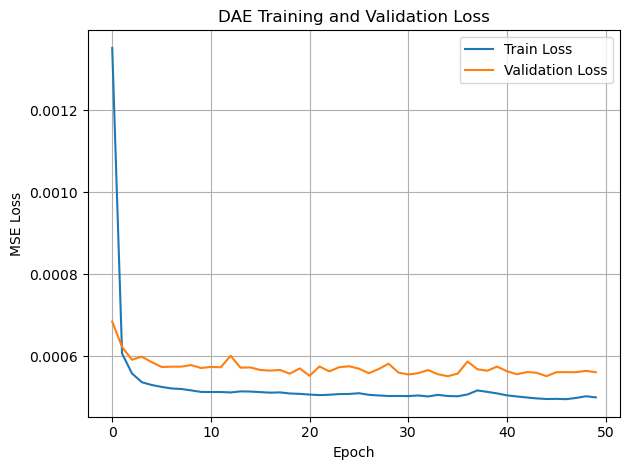

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Normalize on CPU
eps = 1e-8
train_min = train_tensor.min(dim=1, keepdim=True).values
train_max = train_tensor.max(dim=1, keepdim=True).values
train_tensor_norm = (train_tensor - train_min) / (train_max - train_min + eps)

val_min = val_tensor.min(dim=1, keepdim=True).values
val_max = val_tensor.max(dim=1, keepdim=True).values
val_tensor_norm = (val_tensor - val_min) / (val_max - val_min + eps)

# Stay on CPU — no .to(device) here
train_dataset = TensorDataset(train_tensor_norm)
val_dataset = TensorDataset(val_tensor_norm)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# Init model
input_dim = train_tensor.shape[1]
model = DAE(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
n_epochs = 50
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_samples = 0

    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

    avg_train_loss = total_train_loss / total_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            recon = model(x)
            loss = criterion(recon, x)
            total_val_loss += loss.item() * x.size(0)
            val_samples += x.size(0)

    avg_val_loss = total_val_loss / val_samples

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d}/{n_epochs} - Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

# Plot
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("DAE Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# save the model

In [12]:
# Save the model (recommended PyTorch way)
torch.save(model.state_dict(), "dae_model.pth")
print("Model saved to dae_model.pth")


Model saved to dae_model.pth


# load the model

In [7]:
device='cuda'
model = DAE(input_dim=801)
model.load_state_dict(torch.load("dae_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_5756/2109932598.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dae_model.pth", map_location=device))


DAE(
  (encoder): Sequential(
    (0): Linear(in_features=801, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=801, bias=True)
  )
)

In [8]:
model.eval()
device = 'cuda'
model.to(device)



# Move normalized input to device
with torch.no_grad():
    latent_representations = model.encoder(test_tensor.to(device))

# Move to CPU and convert to numpy if needed
latent_representations = latent_representations.cpu()

print("Latent shape:", latent_representations.shape)  # Should be (60, 6)
print("Device", latent_representations.device)

Latent shape: torch.Size([296570, 6])
Device cpu


In [9]:
from torch.utils.data import DataLoader, TensorDataset

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

batch_size = 512  # adjust down if OOM again
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size)

all_latents = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        latent = model.encoder(x)
        all_latents.append(latent.cpu())  # keep on CPU to save GPU mem

latent_representations = torch.cat(all_latents, dim=0)
print("Latent shape:", latent_representations.shape)


Latent shape: torch.Size([296570, 6])


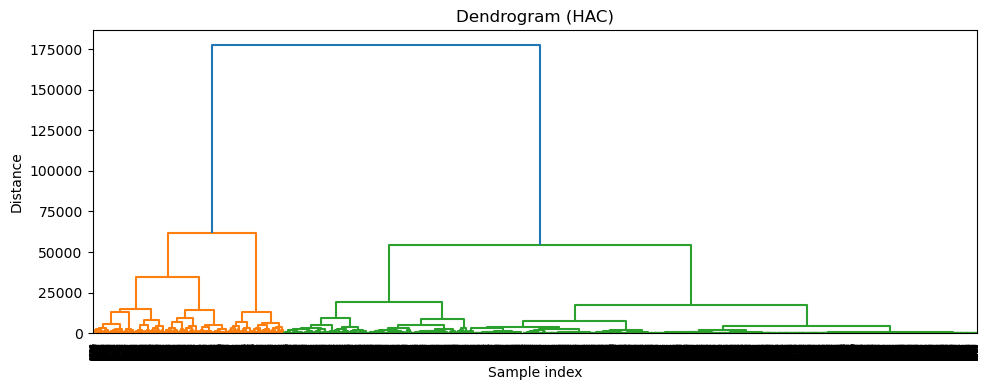

In [19]:


# Convert to numpy if not already
latent_np = latent_representations.numpy()

sampled_latent = latent_np[np.random.choice(latent_np.shape[0], size=10000, replace=False)]

# Optional: dendrogram visualization (just for fun)
linked = linkage(sampled_latent, method='ward')
plt.figure(figsize=(10, 4))
# dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           labels=np.arange(len(sampled_latent)))

plt.title("Dendrogram (HAC)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

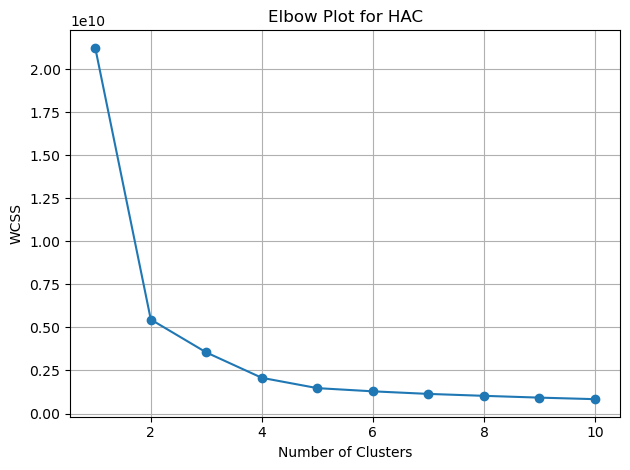

In [20]:

wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(sampled_latent)

    # Compute WCSS manually
    wcss_k = 0
    for cluster_id in np.unique(labels):
        cluster_points = sampled_latent[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distances = np.sum((cluster_points - centroid) ** 2)
        wcss_k += distances

    wcss.append(wcss_k)

# Plot WCSS (elbow)
plt.figure()
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Plot for HAC")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:

# HAC with 5 clusters
hac_5 = AgglomerativeClustering(n_clusters=4)
cluster_labels = hac_5.fit_predict(sampled_latent)

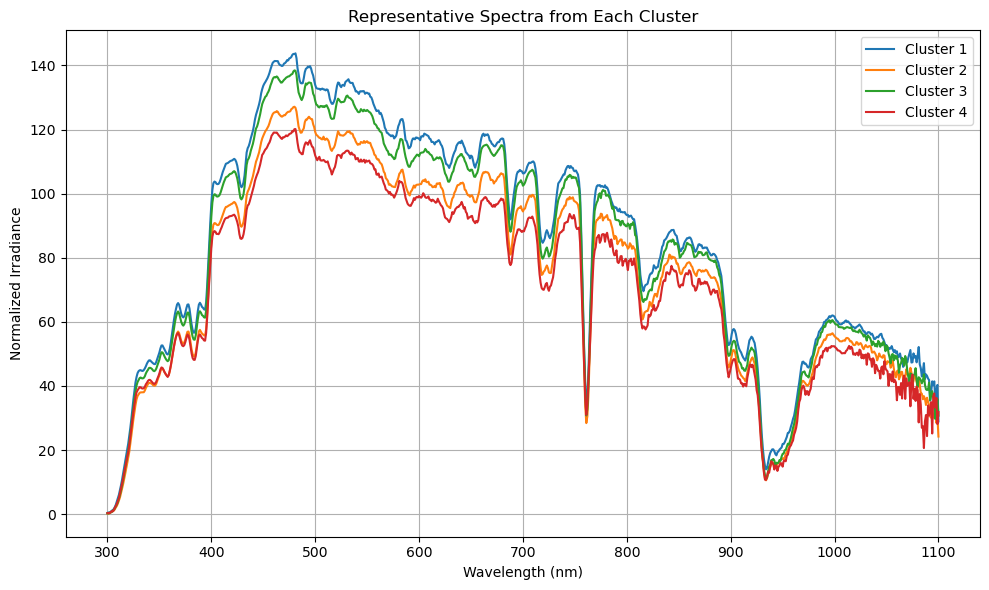

In [24]:

representative_indices = []

for cluster_id in np.unique(cluster_labels):
    # Step 1: Get indices of samples in this cluster
    cluster_idx = np.where(cluster_labels == cluster_id)[0]
    cluster_latents = latent_np[cluster_idx]

    # Step 2: Compute pairwise distances within the cluster
    pairwise_dists = cdist(cluster_latents, cluster_latents, metric='euclidean')

    # Step 3: Sum distances for each sample
    sum_dists = pairwise_dists.sum(axis=1)

    # Step 4: Select index with minimum total distance
    rep_idx_within_cluster = np.argmin(sum_dists)
    rep_idx = cluster_idx[rep_idx_within_cluster]
    representative_indices.append(rep_idx)

# Step 5: Get the corresponding original spectra (denormalized if needed)
rep_spectra = test_tensor[representative_indices].cpu().numpy()

# Step 6: Plot the representative spectra
plt.figure(figsize=(10, 6))
#wavelengths = spectra['Wavelength'].values  # original x-axis
wavelengths = np.arange(300, 1101)

for i, spec in enumerate(rep_spectra):
    plt.plot(wavelengths, spec, label=f'Cluster {i+1}')

plt.title('Representative Spectra from Each Cluster')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Irradiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

green one is red-shift, because it is lower on the left of the peak amd higher on high wavelength